## Download Data

In [1]:
# !wget --no-check-certificate \
#   https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
#   -O cats_and_dogs_filtered.zip
# ! unzip cats_and_dogs_filtered.zip

## System setting and import packages

In [17]:
import os

os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

os.environ["RUNFILES_DIR"] = "/Users/bunnykitty/opt/anaconda3/envs/tf/share/plaidml"
# plaidml might exist in different location. Look for "/usr/local/share/plaidml" and replace in above path

os.environ["PLAIDML_NATIVE_PATH"] = "/Users/bunnykitty/opt/anaconda3/envs/tf/lib/libplaidml.dylib"
# libplaidml.dylib might exist in different location. Look for "/usr/local/lib/libplaidml.dylib" and replace in above path

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, AveragePooling2D,GlobalAveragePooling2D, Flatten
from keras.layers import Dropout
from keras import backend as K
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras import optimizers

import numpy as np

## Vectorize the data

In [18]:
trdata = ImageDataGenerator()
traindata = trdata.flow_from_directory(directory="cats_and_dogs_filtered/train",target_size=(224,224))
tsdata = ImageDataGenerator()
testdata = tsdata.flow_from_directory(directory="cats_and_dogs_filtered/validation", target_size=(224,224))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Setup ResNet50 model

In [4]:
from keras.applications.resnet50 import ResNet50
from keras_applications import resnet

# from keras.layers import Input
# new_input = Input(shape=(224, 224, 3))
# model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), classes=2)
resnet_model = resnet.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), 
#                         classes=2,
                        backend=keras.backend,
                        layers=keras.layers,
                        models=keras.models,
                        utils=keras.utils)

for layer in resnet_model.layers:
    layer.trainable = False
    
resnet_model.summary()


INFO:plaidml:Opening device "metal_amd_radeon_pro_5500m.0"


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________________________________________________________________________________
conv1_relu

In [5]:
resnet_model.trainable = True
set_trainable = False
# for layer in resnet_model.layers:
#     print(layer.name)
for layer in resnet_model.layers:
    if layer.name in ['conv5_block3_2_conv', 'conv5_block3_3_conv', 'conv5_block3_2_relu', 'conv5_block2_out']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
resnet_model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________________________________________________________________________________
conv1_relu

In [6]:
import pandas as pd
layers_property = [(layer, layer.name, layer.trainable) for layer in resnet_model.layers]
layers_df=pd.DataFrame(layers_property, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])
pd.set_option("max_rows", None)
layers_df

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at...,input_1,False
1,<keras.layers.convolutional.ZeroPadding2D obje...,conv1_pad,False
2,<keras.layers.convolutional.Conv2D object at 0...,conv1_conv,False
3,<keras.layers.normalization.BatchNormalization...,conv1_bn,False
4,<keras.layers.core.Activation object at 0x7f98...,conv1_relu,False
5,<keras.layers.convolutional.ZeroPadding2D obje...,pool1_pad,False
6,<keras.layers.pooling.MaxPooling2D object at 0...,pool1_pool,False
7,<keras.layers.convolutional.Conv2D object at 0...,conv2_block1_1_conv,False
8,<keras.layers.normalization.BatchNormalization...,conv2_block1_1_bn,False
9,<keras.layers.core.Activation object at 0x7f98...,conv2_block1_1_relu,False


In [7]:
# from keras.applications.resnet152 import ResNet152

# model = ResNet152(weights='imagenet', include_top=False, input_shape=(224, 224, 3), classes=2)

# model.summary()

In [8]:
from keras.layers import BatchNormalization
model = Sequential()
# model.add(UpSampling2D())
# model.add(UpSampling2D())
# model.add(UpSampling2D())
model.add(resnet_model)
model.add(GlobalAveragePooling2D())
# model.add(MaxPool2D())
model.add(Dense(512, activation='relu'))
model.add(Dropout(.25))
model.add(BatchNormalization())
model.add(Dense(2, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1026      
Total params: 24,639,874
Trainable params: 5,516,802
Non-trainable params: 19,123,072
________________________________________________________

In [9]:

# x = resnet_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dropout(0.7)(x)
# predictions = Dense(2, activation= 'softmax')(x)
# model = Model(inputs = resnet_model.input, outputs = predictions)
# model.summary()

In [10]:
# output = resnet_model.output
# output = keras.layers.Flatten()(output)
# output = Dense(2, activation="softmax")(output)
# model = Model(resnet_model.input, output=output)
# model.summary()

## Visualize the model

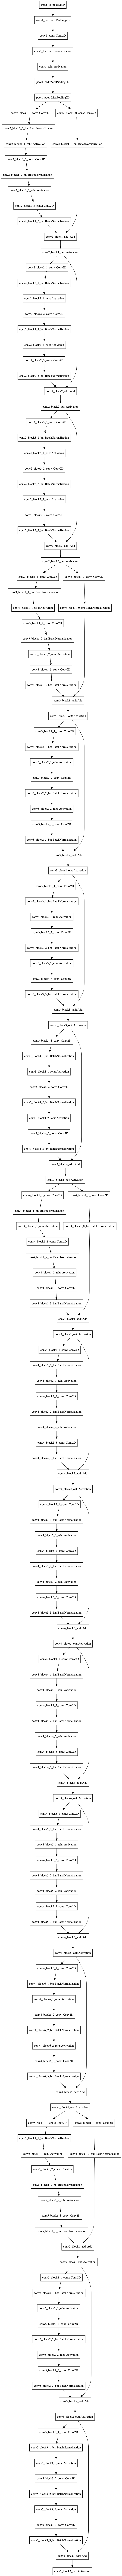

In [40]:
# from keras.utils import plot_model
from tensorflow.keras.utils import plot_model
plot_model(resnet_model, to_file='resnet50partial.png')

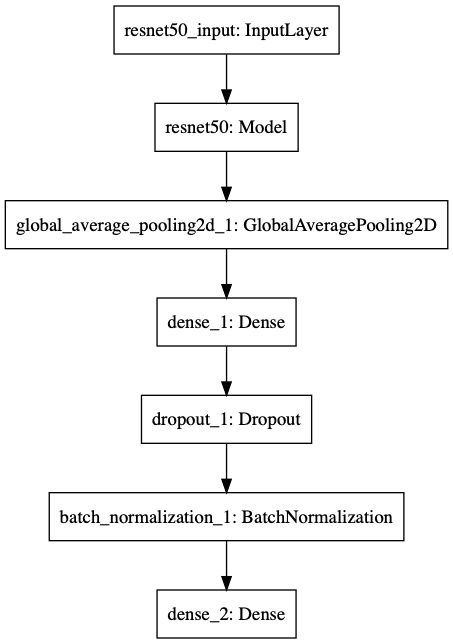

In [39]:
plot_model(model, to_file='resnet50partialcustomized.png')

## ModelCheckpoint and EarlyStopping

In [12]:
# from keras.callbacks import ModelCheckpoint, EarlyStopping
# checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
# early = EarlyStopping(monitor='val_acc', min_delta=0, patience=40, verbose=1, mode='auto')
# model_final.fit_generator(generator= traindata, steps_per_epoch= 2, epochs= 100, validation_data= testdata, validation_steps=1, callbacks=[checkpoint,early])
# model_final.save_weights("vgg16_1.h5")

In [13]:

opt = Adam(lr=0.001)
# opt=optimizers.SGD(lr=0.0001, momentum=0.9)
# opt=optimizers.RMSprop(lr=2e-5)
# for layers in (vggmodel.layers)[:19]:
#     print(layers)
#     layers.trainable = False
    

model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics=["accuracy"])


In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
# filepath="vgg16_{epoch:02d}-{val_acc:.2f}.hdf5"
model_filepath="saved_model/resnet50_imagenet_2.h5"
checkpoint = ModelCheckpoint(model_filepath, 
                             monitor='val_acc', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='auto', 
                             period=1)
early = EarlyStopping(monitor='val_acc', 
                      min_delta=0, 
                      patience=40, 
                      verbose=1, 
                      mode='auto')
hist = model.fit_generator(steps_per_epoch=20,
                           generator=traindata, 
                           validation_data= testdata, 
                           validation_steps=10,
                           epochs=100,
                           callbacks=[checkpoint,early])
model.save_weights("saved_model/resnet50_imagenet_weights_2.h5")
model.save(model_filepath)

## visualize

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history["acc"])
plt.plot(hist.history['val_acc'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

## Validate the trained model

In [36]:
from keras.preprocessing import image
from keras.models import load_model
model_filepath="saved_model/resnet50_imagenet_2.h5"
saved_model = load_model(model_filepath)

cat


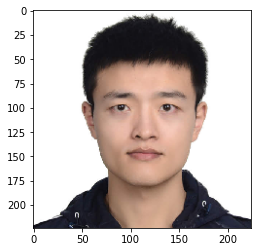

In [37]:
testimgpath="cats_and_dogs_filtered/validation/cats/cat.2001.jpg"
testimgpath="testimg/image1.jpeg"
testimgpath="testimg/liang.JPG"
img = image.load_img(testimgpath,target_size=(224,224))
img = np.asarray(img)
import matplotlib.pyplot as plt
plt.imshow(img)
img = np.expand_dims(img, axis=0)

output = saved_model.predict(img)

if output[0][0] > output[0][1]:
    print("cat")
else:
    print('dog')